In [1]:
!pip install polygon-api-client

In [2]:
%run Polygon_API.ipynb

In [5]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "jax"
import keras

from keras import layers

import jax.numpy as jnp
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# First Attemp: MLP

In [108]:
#Note: run the following to obtain VOO_smooth_0.8.csv:
# df = get_all_features('VOO', '2022-01-01', '2025-01-31', alpha = 0.8, smoothing = True, d = 7)
# df.to_csv('VOO_smooth_0.8.csv')

df_train = pd.read_csv('CMG_smooth_0.8.csv', index_col = 0)
df_train = df_train.drop('Target', axis = 1)
df_val = pd.read_csv('OPK_smooth_0.8.csv', index_col = 0)
df_val = df_val.drop('Target', axis = 1)

In [109]:
# create target values
# target indicates whether or not stock price will rise after 7 days
# i.e. if target = 1 at Jan 1, 2025, then price will be higher on Jan 8, 2025

df_train['Target'] = (df_train['Close'].shift(-7) - df_train['Close']).apply(np.sign)
df_val['Target'] = (df_val['Close'].shift(-7) - df_val['Close']).apply(np.sign)

df_train = df_train.dropna()
df_val = df_val.dropna()

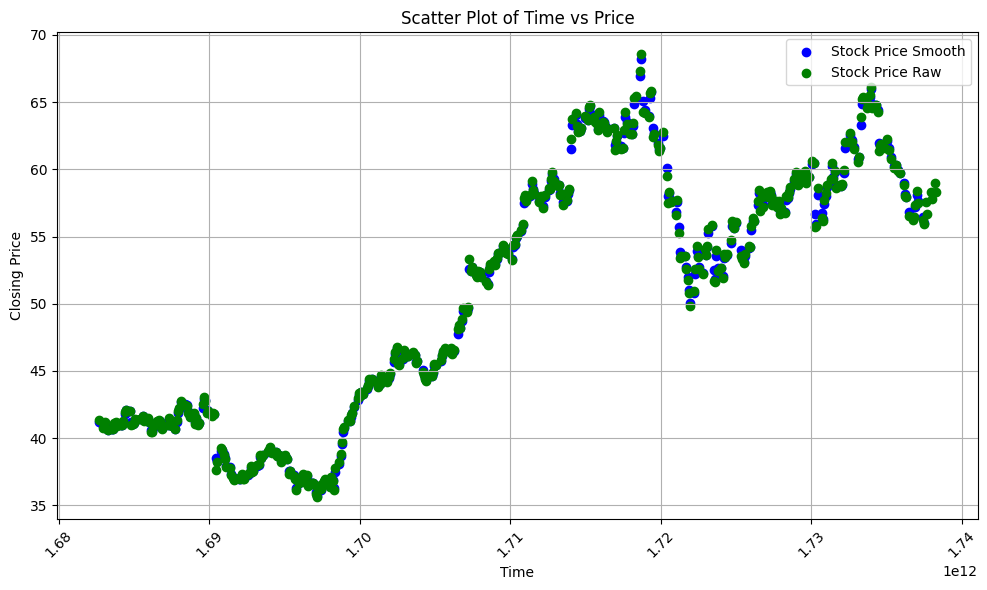

In [110]:
# unsmooth data for graphical comparison
df_unsmooth = pd.read_csv('CMG_unsmooth.csv', index_col = 0)

# Create scatter plot for both series
plt.figure(figsize=(10, 6))
plt.scatter(df_train['Timestamp'], df_train['Close'], color = 'blue', label = 'Stock Price Smooth')
plt.scatter(df_unsmooth['Timestamp'], df_unsmooth['Close'], color = 'green', label = 'Stock Price Raw')
# plt.scatter(df['Timestamp'], df['Target'], color = 'red', label = 'Target')
plt.title('Scatter Plot of Time vs Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [111]:
# drop columns not used in training
df_train = df_train[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R', 'Target']]
df_val = df_val[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R', 'Target']]

le = LabelEncoder()

# get training observations and labels
y_train = le.fit_transform(df_train['Target'])
X_train = df_train[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R']]
X_train = np.array(X_train, dtype = np.float32)

# get validation observations and labels
y_val = le.fit_transform(df_val['Target'])
X_val = df_train[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R']]
X_val = np.array(X_val, dtype = np.float32)

# X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.3)

In [112]:
model1 = keras.models.Sequential([
    layers.Input((10,)),  # each input has 10 features
    layers.Dense(512, activation = 'relu'),  #hidden layer with 500 units and relu activation
    layers.Dense(512, activation = 'relu'),  #hidden layer with 500 units and relu activation
    layers.Dense(512, activation = 'relu'),  #hidden layer with 500 units and relu activation
    layers.Dense(2)     # output layer, represents the two labels
])

In [113]:
model1.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                     │ (None, 512)                 │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 531,970 (2.03 MB)

 Trainable params: 531,970 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

In [114]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
model1.compile(optimizer= "adam", loss = loss_fn, metrics = ["accuracy"])

In [115]:
history = model1.fit(X_train, y_train, epochs = 150,  validation_data = (X_val, y_val), verbose = 1)

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5665 - loss: 7.0399 - val_accuracy: 0.5126 - val_loss: 1.5495
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4867 - loss: 1.2400 - val_accuracy: 0.4897 - val_loss: 1.0692
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5787 - loss: 0.8365 - val_accuracy: 0.5080 - val_loss: 0.8639
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5459 - loss: 0.7031 - val_accuracy: 0.5057 - val_loss: 0.7284
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5962 - loss: 0.6690 - val_accuracy: 0.5402 - val_loss: 0.7589
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5835 - loss: 0.7019 - val_accuracy: 0.4920 - val_loss: 0.7475
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6486 - loss: 0.6576 - val_accuracy: 0.5011 - val_loss: 0.7395
Epoch 8/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5718 - loss: 0.6414 - val_accuracy: 0.4920 - 

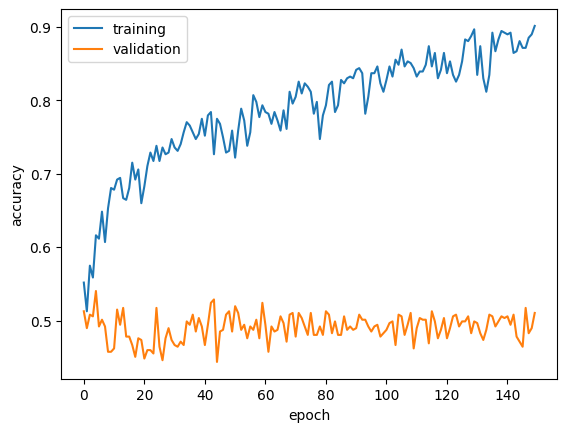

In [116]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

# Second Attempt: 1D CNN

In [117]:
from keras import datasets, layers, models
from scipy.signal import convolve2d

In [118]:
alpha = 0.8   # exponential smoothing parameter
d = 7         # number of days for prediction

df_train = pd.read_csv('CMG_smooth_0.8.csv', index_col = 0)
df_val = pd.read_csv('OPK_smooth_0.8.csv', index_col = 0)

In [119]:
# drop columns not used in training
df_train = df_train[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R', 'Target']]
df_val = df_val[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R', 'Target']]

le = LabelEncoder()

# get training observations and labels
y_train = le.fit_transform(df_train['Target'])
X_train = df_train[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R']]
X_train = np.array(X_train, dtype = np.float32)

# get validation observations and labels
y_val = le.fit_transform(df_val['Target'])
X_val = df_train[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R']]
X_val = np.array(X_val, dtype = np.float32)

# X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.3)

In [120]:
# Define the model
model2 = models.Sequential([
    layers.Input((10, 1)),  # Input shape: (10, 1)
    layers.Conv1D(32, kernel_size = 4, activation = 'relu', padding = 'same'),  # 1D convolution
    layers.MaxPooling1D(pool_size = 2),  # 1D pooling
    layers.Conv1D(64, kernel_size = 4, activation = 'relu', padding ='same'),  # 1D convolution
    layers.MaxPooling1D(pool_size = 2),  # 1D pooling
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(2)  # Number of classes
])

In [121]:
model2.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 10, 32)              │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 5, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 5, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,802 (65.63 KB)

 Trainable params: 16,802 (65.63 KB)

 Non-trainable params: 0 (0.00 B)

In [122]:
model2.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model2.fit(X_train, y_train, epochs = 150, validation_data = (X_val, y_val), verbose = 1)

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.6786 - loss: 1.2135 - val_accuracy: 0.5656 - val_loss: 2.7495
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8960 - loss: 0.4719 - val_accuracy: 0.5656 - val_loss: 1.7814
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8562 - loss: 0.3500 - val_accuracy: 0.5679 - val_loss: 1.6666
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8733 - loss: 0.3172 - val_accuracy: 0.5611 - val_loss: 1.7124
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8632 - loss: 0.3023 - val_accuracy: 0.5656 - val_loss: 1.5965
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8850 - loss: 0.2752 - val_accuracy: 0.5566 - val_loss: 1.2327
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8575 - loss: 0.2943 - val_accuracy: 0.5498 - val_loss: 1.4454
Epoch 8/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8820 - loss: 0.2608 - val_accuracy: 0.5543 -

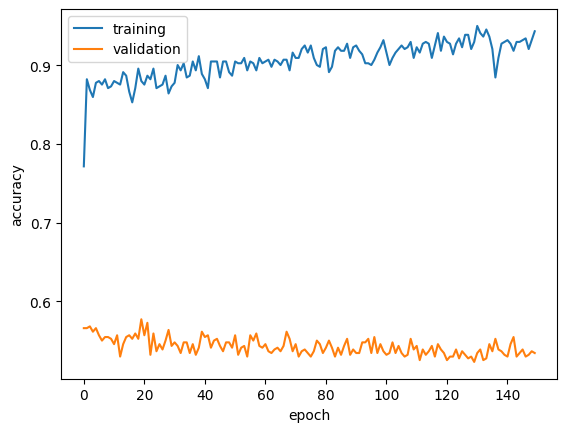

In [123]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

# Third Attempt: 2D CNN

In [124]:
alpha = 0.8   # exponential smoothing parameter
d = 7         # number of days for prediction

df_train = pd.read_csv('CMG_smooth_0.8.csv', index_col = 0)
df_val = pd.read_csv('OPK_smooth_0.8.csv', index_col = 0)

In [125]:
X_training = []
y_training = []
X_validation = []
y_validation = []

for start in range(0, len(df_train) - 14):
  end = start + 14
  window = df_train[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R']].iloc[start: end].to_numpy()
  target = df_train['Target'].iloc[end]
  X_training.append(window)
  y_training.append(target)

for start in range(0, len(df_val) - 14):
  end = start + 14
  window = df_val[['Close', 'High', 'Low', 'MACD Value', 'Signal', 'RSI Value', '%K', '%D', '%J', 'Williams %R']].iloc[start: end].to_numpy()
  target = df_val['Target'].iloc[end]
  X_validation.append(window)
  y_validation.append(target)

X_training = np.array(X_training, dtype = np.float32)
y_training = le.fit_transform(y_training)

X_validation = np.array(X_validation, dtype = np.float32)
y_validation = le.fit_transform(y_validation)

In [126]:
model3 = models.Sequential([
    layers.Input((14, 10, 1)),
    layers.Conv2D(32, (7, 10), padding = 'same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (7, 10), padding = 'same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (7, 10), padding = 'same',activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10) # number of classes
])

In [127]:
print(X_training.shape, y_training.shape, X_validation.shape, y_validation.shape)

(428, 14, 10) (428,) (428, 14, 10) (428,)


In [128]:
model3.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 14, 10, 32)          │           2,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 7, 5, 32)            │          71,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 3, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 3, 2, 64)            │         143,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 64)                  │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 242,698 (948.04 KB)

 Trainable params: 242,698 (948.04 KB)

 Non-trainable params: 0 (0.00 B)

In [129]:
model3.compile(optimizer = 'adam',
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

history = model3.fit(X_training,
                    y_training,
                    epochs = 150,
                    validation_data=(X_validation, y_validation))

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.4356 - loss: 1.4267 - val_accuracy: 0.7150 - val_loss: 0.6205
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7448 - loss: 0.5627 - val_accuracy: 0.6332 - val_loss: 0.7006
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8076 - loss: 0.4683 - val_accuracy: 0.8107 - val_loss: 0.4613
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8108 - loss: 0.3965 - val_accuracy: 0.8248 - val_loss: 0.4285
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8344 - loss: 0.3505 - val_accuracy: 0.7921 - val_loss: 0.4202
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8659 - loss: 0.3330 - val_accuracy: 0.7897 - val_loss: 0.4428
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8353 - loss: 0.3443 - val_accuracy: 0.7664 - val_loss: 0.4655
Epoch 8/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8621 - loss: 0.3267 - val_accuracy: 0.7850 -

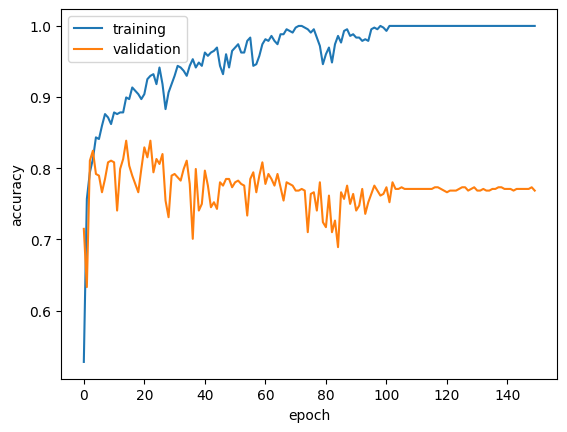

In [130]:
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()